In [198]:
import numpy as np
from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers import LSTM, Input, Masking
from keras.utils.np_utils import to_categorical
import keras

In [82]:
from pointer_lstm import PointerDecoder
from sorting_dataset import gen_data

In [83]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [84]:
%reload_ext autoreload
%autoreload 2

In [85]:
N = 10000
seq_len = 5
output_size = 5
X, y = gen_data(N, seq_len, low=0, high=1000)

In [109]:
split = int(0.8 * N)

_X = X / np.expand_dims(X.max(axis=1), axis=1)
_X = np.expand_dims(_X, axis=2)
# _X = np.repeat(_X, 4, axis=2)

_y = to_categorical(y)
_y = _y[:, :output_size]

X_train = _X[:split]
y_train = _y[:split]

X_test = _X[split:]
y_test = _y[split:]

X_train.shape, y_train.shape

((8000, 5, 1), (8000, 5, 5))

In [110]:
# X_train[:, 0] = -1

In [182]:
seq_shape = X_train.shape[1:]
hidden_units = 32
batch_size = 16

inputs = Input(shape=seq_shape, name='input', batch_size=batch_size)
masked = Masking(mask_value=-1, name='masking') (inputs)
encoder = LSTM(hidden_units, name='encoder', return_sequences=True, return_state=True)
enc, state_h, state_c =  encoder(masked)

decoder = PointerDecoder(hidden_units, output_size=output_size, name='decoder')
dec = decoder(enc, initial_state=[state_h, state_c])

model = Model(inputs, dec)
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(16, 5, 1)]         0           []                               
                                                                                                  
 masking (Masking)              (16, 5, 1)           0           ['input[0][0]']                  
                                                                                                  
 encoder (LSTM)                 [(16, 5, 32),        4352        ['masking[0][0]']                
                                 (16, 32),                                                        
                                 (16, 32)]                                                        
                                                                                           

In [183]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [184]:
nb_epochs = 100
h = model.fit(X_train, y_train,
            epochs=nb_epochs, batch_size=batch_size)

Epoch 1/100
500/500 [==============================] - 11s 6ms/step - loss: 0.9501 - accuracy: 0.5787
Epoch 2/100
500/500 [==============================] - 3s 6ms/step - loss: 0.3503 - accuracy: 0.8781
Epoch 3/100
500/500 [==============================] - 3s 6ms/step - loss: 0.2389 - accuracy: 0.9212
Epoch 4/100
500/500 [==============================] - 3s 6ms/step - loss: 0.1831 - accuracy: 0.9405
Epoch 5/100
500/500 [==============================] - 3s 6ms/step - loss: 0.1517 - accuracy: 0.9504
Epoch 6/100
500/500 [==============================] - 3s 6ms/step - loss: 0.1326 - accuracy: 0.9549
Epoch 7/100
500/500 [==============================] - 3s 6ms/step - loss: 0.1197 - accuracy: 0.9584
Epoch 8/100
500/500 [==============================] - 3s 6ms/step - loss: 0.1075 - accuracy: 0.9627
Epoch 9/100
500/500 [==============================] - 3s 6ms/step - loss: 0.0991 - accuracy: 0.9653
Epoch 10/100
500/500 [==============================] - 3s 6ms/step - loss: 0.0950 - accur

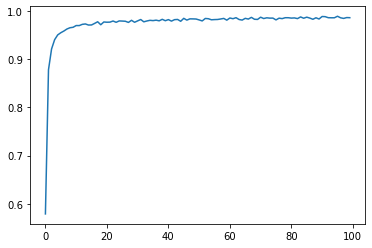

In [185]:
plt.plot(h.history['accuracy'])

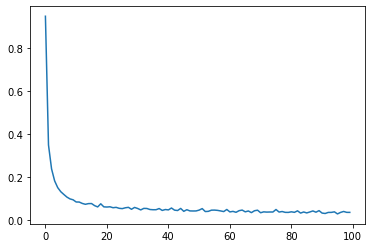

In [186]:
plt.plot(h.history['loss'])

In [229]:
model.evaluate(X_test[:-16], y_test[:-16], batch_size=batch_size)

124/124 [==============================] - 0s 3ms/step - loss: 0.1007 - accuracy: 0.9775


[0.10071972757577896, 0.9775156378746033]

In [230]:
X_test[:2]

array([[[ 0.2],
        [ 1. ],
        [ 0. ],
        [-1. ],
        [-1. ]],

       [[ 1. ],
        [ 1. ],
        [ 1. ],
        [ 1. ],
        [ 1. ]]])

In [231]:
y_pred = model.predict(X_test[:-16])

In [232]:
y_pred_pos = y_pred.argmax(axis=2)
y_pred_idx = y_pred.argmax(axis=1)
y_pred_pos[:2], y_pred_idx[:2]

(array([[2, 0, 0, 1, 1],
        [0, 0, 2, 2, 1]]),
 array([[1, 3, 0, 0, 0],
        [1, 4, 3, 0, 0]]))

In [234]:
def compute_accuracy(_y_true, _y_pred):
    acc = keras.metrics.Accuracy()
    return acc(_y_true, _y_pred).numpy()

In [235]:
compute_accuracy(y_pred_idx.argsort(), y_pred_pos)

0.98185486

In [236]:
y_test_pos = y_test.argmax(axis=2)
y_test_idx = y_test.argmax(axis=1)
y_test_pos[:2], y_test_idx[:2]

(array([[4, 3, 2, 1, 0],
        [1, 2, 4, 3, 0]]),
 array([[4, 3, 2, 1, 0],
        [4, 0, 1, 3, 2]]))

In [237]:
compute_accuracy(y_test_idx.argsort(), y_test_pos)

1.0

In [242]:
compute_accuracy(y_pred_pos, y_test_pos[:-16])

0.97379035

In [243]:
compute_accuracy(y_pred_idx, y_test_idx[:-16])

0.97752017

In [244]:
X_ = X_test[:batch_size]
X_[0] = [[0.2], [1.0], [0.0], [-1], [-1]]
X_[1] = [[1.0], [1.0], [1.0], [1.0], [1.0]]
X_[2] = [[1], [0.1], [0.1], [1], [0.1]]

In [245]:
y_pred = model.predict(X_)
y_pred_pos = y_pred.argmax(axis=2)
y_pred_idx = y_pred.argmax(axis=1)
y_pred_pos[:3], y_pred_idx[:3]

(array([[2, 0, 0, 1, 1],
        [0, 0, 2, 2, 1],
        [2, 1, 1, 0, 0]]),
 array([[1, 3, 0, 0, 0],
        [1, 4, 3, 0, 0],
        [4, 1, 0, 0, 0]]))

In [247]:
# y_pred[:3]